函數(For Anova)

In [87]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from scipy.stats import bartlett, shapiro
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
def oneway_anova(df, response_col, factor_col):
    """
    Runs a one-way ANOVA on the given dataframe.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - response_col: name of the numeric response variable
    - factor_col: name of the categorical factor

    Returns:
    - ANOVA summary table (DataFrame)
    """
    
    formula = f'{response_col} ~ C({factor_col})'
    model = ols(formula, data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    
    print("\nANOVA Table:")
    display(aov_table)
    
    return aov_table

def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

函數(f test, t test)

In [89]:
def f_test_variances(x1, x2, sides, alpha):
    # Convert input to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((7, 2), None, dtype=float)
    
    # Calculate basic statistics
    result[0] = [np.mean(a1), np.mean(a2)]                    # Means
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]      # Sample standard deviations
    result[2] = [a1.size, a2.size]                            # Sample sizes

    # Degrees of freedom
    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    # F-statistic: ratio of sample variances
    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    # Critical F-values
    if sides > 1:
        result[5] = [
            stats.f.isf(alpha / 2, dfn, dfd),  # Upper critical value
            stats.f.ppf(alpha / 2, dfn, dfd)   # Lower critical value
        ]
    else:
        result[5] = [
            stats.f.isf(alpha, dfn, dfd),      # One-sided critical value
            stats.f.ppf(alpha, dfn, dfd)
        ]

    # P-value calculation
    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    # Create labeled DataFrame
    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    df = pd.DataFrame(result, index=labels)

    return df

def t_test_two_means_unequal_variance(x1, x2, sides, alpha, H0_diff):
    # Convert inputs to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((8, 2), None, dtype=float)

    # Basic statistics
    mean1, mean2 = np.mean(a1), np.mean(a2)
    var1, var2 = np.var(a1, ddof=1), np.var(a2, ddof=1)
    n1, n2 = a1.size, a2.size

    result[0] = [mean1, mean2]  # Means
    result[1] = [var1, var2]    # Variances
    result[2] = [n1, n2]        # Sample sizes

    # Mean difference and its variance
    mean_diff = mean1 - mean2
    diff_var = var1 / n1 + var2 / n2

    # Hypothesized difference under H0
    result[3, 0] = H0_diff

    # Degrees of freedom (Welch-Satterthwaite equation)
    numerator = diff_var ** 2
    denominator = (var1**2 / (n1**2 * (n1 - 1))) + (var2**2 / (n2**2 * (n2 - 1)))
    df = numerator / denominator
    result[4, 0] = df

    # t-statistic
    t_stat = (mean_diff - H0_diff) / np.sqrt(diff_var)
    result[5, 0] = t_stat

    # Critical t-values
    if sides > 1:
        result[6] = [stats.t.isf(alpha / 2, df), stats.t.ppf(alpha / 2, df)]
    else:
        result[6] = [stats.t.isf(alpha, df), stats.t.ppf(alpha, df)]

    # p-value
    if t_stat > 0:
        p_value = 1 - stats.t.cdf(t_stat, df)
    else:
        p_value = stats.t.cdf(t_stat, df)
    if sides > 1:
        p_value *= 2
    result[7, 0] = p_value

    # Create labeled DataFrame
    labels = [
        'Mean', 'Variance', 'Size', 'H0 Diff',
        'Degrees of Freedom', 't-statistic', 't-critical', 'p-value'
    ]
    df = pd.DataFrame(result, index=labels)

    return df


def run_t_test_summary(df, col1, col2, usevar='pooled', alpha=0.05):
    """
    Runs a t-test using statsmodels' CompareMeans and prints a summary.

    Parameters:
    - df: DataFrame containing the columns
    - col1, col2: Column names to compare
    - usevar: 'pooled' (equal variances) or 'unequal' (Welch)
    - alpha: Significance level
    """
    group1 = sms.DescrStatsW(df[col1].values)
    group2 = sms.DescrStatsW(df[col2].values)
    t_test = sms.CompareMeans(group1, group2)
    
    return t_test.summary(usevar=usevar, alpha=alpha)



任務一


In [90]:
# ========== 開始作檢定==========

df = pd.read_csv('movie_summary.csv')

# filter data
filtered_df = df[
    (df['production_year'] > 2000) &
    (df['production_budget'] > 0) &
    (df['production_budget'] < 5000000) &
    df['sequel'].notna() &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

# 計算總票房
filtered_df['total_box_office'] = (
    filtered_df['domestic_box_office'] + filtered_df['international_box_office']
)

filtered_df['log_total_box_office'] = np.log1p(filtered_df['total_box_office'])

print(filtered_df['log_total_box_office'].head())

424    18.707935
648    18.458747
753    18.225166
783    18.578413
784    17.646816
Name: log_total_box_office, dtype: float64


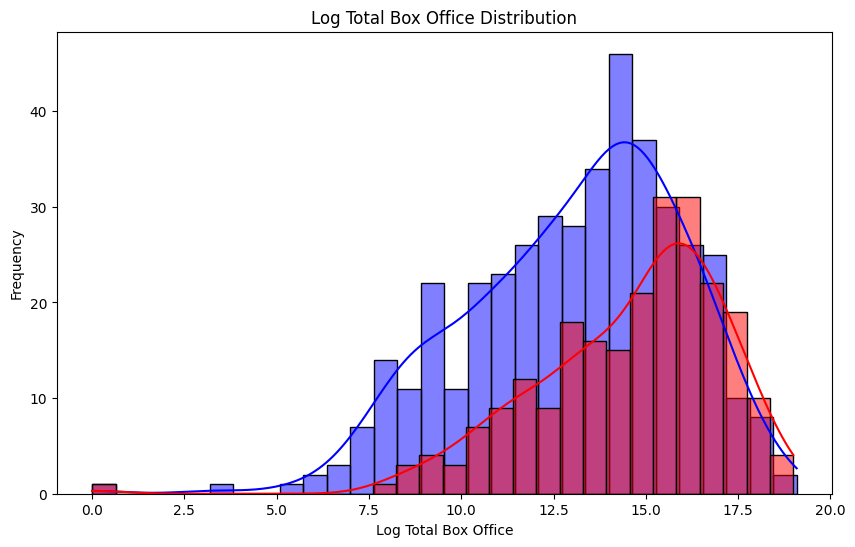

Budget Low 資料筆數：419
Budget High 資料筆數：236


In [91]:
# 新增 budget 分類
filtered_df['budget_category'] = pd.cut(filtered_df['production_budget'], bins=[10000, 2000000
, 5000000], labels=['Low', 'High'])

# 分組資料
budget_low = filtered_df[filtered_df['budget_category'] == 'Low']['log_total_box_office']
budget_high = filtered_df[filtered_df['budget_category'] == 'High']['log_total_box_office']

# Plot log_total_box_office for two groups
plt.figure(figsize=(10, 6))
sns.histplot(budget_low, bins=30, kde=True, color='blue')
sns.histplot(budget_high, bins=30, kde=True, color='red')
plt.title('Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

# 寫出各個的資料筆數
print(f"Budget Low 資料筆數：{len(budget_low)}")
print(f"Budget High 資料筆數：{len(budget_high)}")


常態性檢定結果 (Shapiro-Wilk test)：

Budget Low 組：
樣本數：419
統計量：0.9729
p值：0.0000
結論：不符合常態分配
常態性檢定結果 (Shapiro-Wilk test)：

Budget High 組：
樣本數：236
統計量：0.9276
p值：0.0000
結論：不符合常態分配


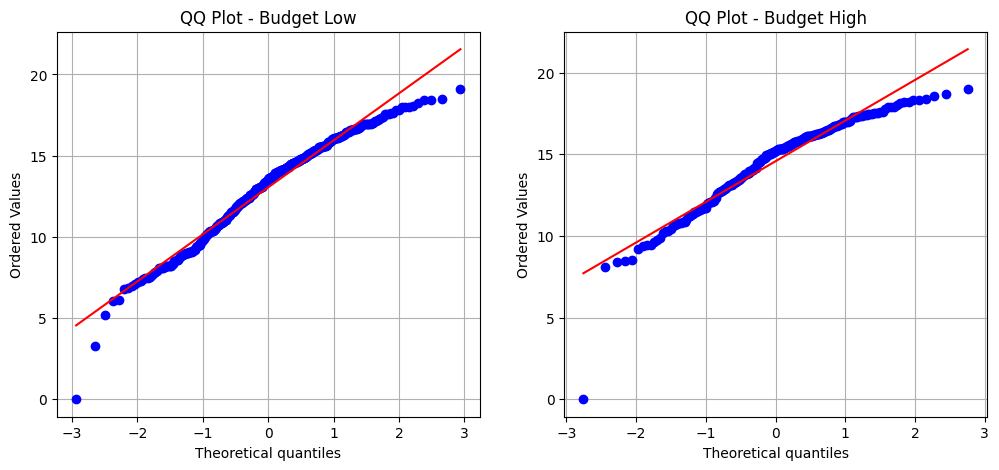

In [92]:
# 常態性檢定 (Shapiro-Wilk test)
from scipy import stats

print("常態性檢定結果 (Shapiro-Wilk test)：")
print("\nBudget Low 組：")
stat, p_value = stats.shapiro(budget_low)
print(f"樣本數：{len(budget_low)}")
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'符合常態分配' if p_value > 0.05 else '不符合常態分配'}")


print("常態性檢定結果 (Shapiro-Wilk test)：")
print("\nBudget High 組：")
stat, p_value = stats.shapiro(budget_high)
print(f"樣本數：{len(budget_high)}")
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'符合常態分配' if p_value > 0.05 else '不符合常態分配'}")

# 用 QQ plot 輔助
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(budget_low, dist="norm", plot=plt)
plt.title("QQ Plot - Budget Low")
plt.grid(True)
plt.subplot(1, 2, 2)
stats.probplot(budget_high, dist="norm", plot=plt)
plt.title("QQ Plot - Budget High")
plt.grid(True)
plt.show()

Sharipo跟QQ plot結論有待討論，資料不一定常態，所以變異數分析用 Levene Test


In [93]:
# 變異數同質性檢定 (Levene's test)
print("\n變異數同質性檢定 (Levene's test)：")
stat, p_value = stats.levene(budget_low, budget_high)
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'變異數同質' if p_value > 0.05 else '變異數不同質'}")

# 變異數不同質所以用 kruskal-wallis test
kruskal_result = stats.kruskal(budget_low, budget_high)
print(f"\nKruskal-Wallis 統計量：{kruskal_result.statistic:.4f}")
print(f"p值：{kruskal_result.pvalue:.4f}")
print(f"結論：{'兩組平均數無顯著差異' if kruskal_result.pvalue > 0.05 else '兩組平均數有顯著差異'}")


變異數同質性檢定 (Levene's test)：
統計量：7.0817
p值：0.0080
結論：變異數不同質

Kruskal-Wallis 統計量：45.4041
p值：0.0000
結論：兩組平均數有顯著差異


以下的程式有兩種test，一種是假設兩組資料常態(welch's t test)，另一組是有一組以上資料不常態(mann-whitney u test)雖然結論都一樣

In [94]:
# 如果是兩組資料常態：welch's t test
t_result = t_test_two_means_unequal_variance(budget_low, budget_high, sides=1, alpha=0.05, H0_diff=0)

print("Welch T-Test 結果：")
print(t_result)
print(f"兩組平均數無顯著差異" if t_result.iloc[7, 0] > 0.05 else "兩組平均數有顯著差異")
print("\n")

# 如果兩組資料不常態：mann-whitney u test
mann_whitney_result = stats.mannwhitneyu(budget_low, budget_high)
print("Mann-Whitney U Test 結果：")
print(f"\n統計量：{mann_whitney_result.statistic:.4f}")
print(f"p值：{mann_whitney_result.pvalue:.4f}")
print(f"結論：{'兩組平均數無顯著差異' if mann_whitney_result.pvalue > 0.05 else '兩組平均數有顯著差異'}")


Welch T-Test 結果：
                               0           1
Mean                1.304957e+01   14.569105
Variance            8.532335e+00    6.601960
Size                4.190000e+02  236.000000
H0 Diff             0.000000e+00         NaN
Degrees of Freedom  5.406051e+02         NaN
t-statistic        -6.911411e+00         NaN
t-critical          1.647677e+00   -1.647677
p-value             6.780030e-12         NaN
兩組平均數有顯著差異


Mann-Whitney U Test 結果：

統計量：33775.5000
p值：0.0000
結論：兩組平均數有顯著差異


任務二

budget_low_df的資料筆數： 419
Romantic Comedy 資料筆數： 17
Thriller/Suspense 資料筆數： 38
Comedy 資料筆數： 68
Drama 資料筆數： 160


budget_high_df的資料筆數： 236
Romantic Comedy 資料筆數： 9
Thriller/Suspense 資料筆數： 27
Comedy 資料筆數： 37
Drama 資料筆數： 95


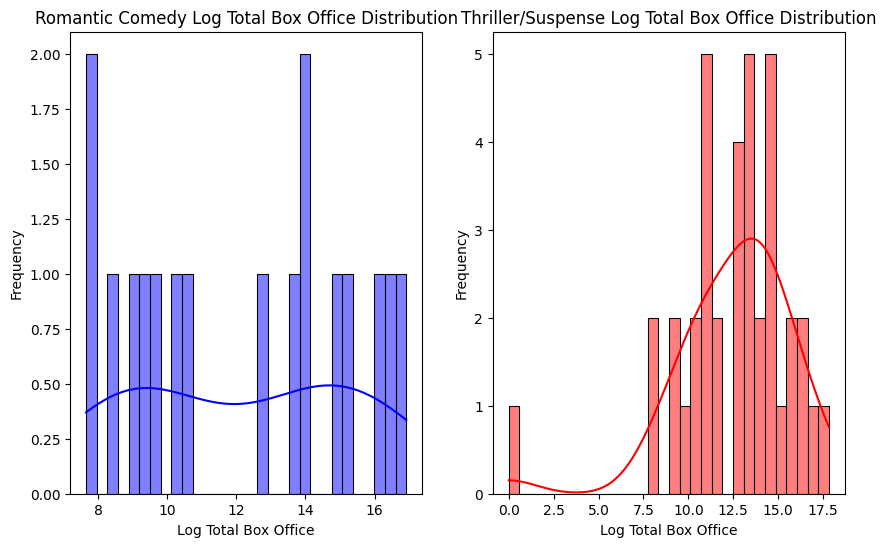

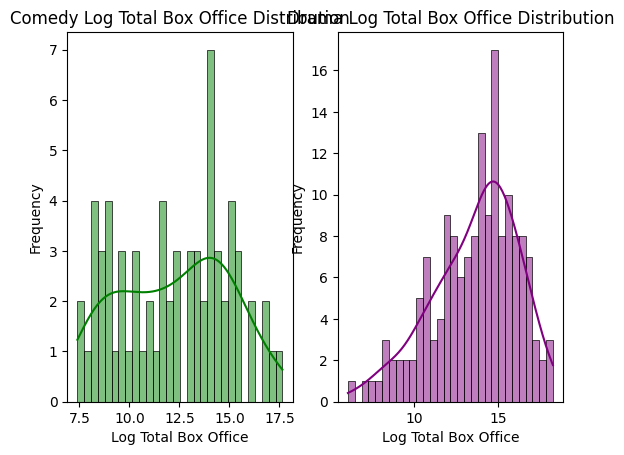

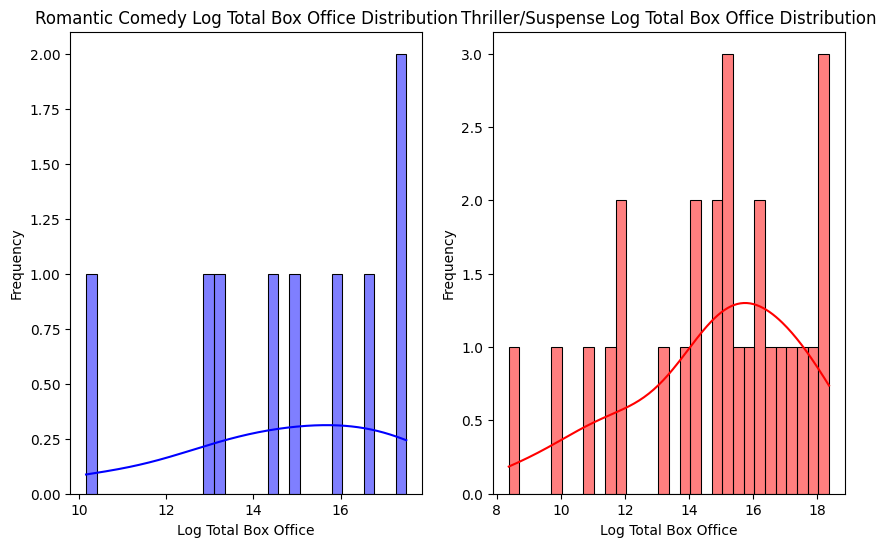

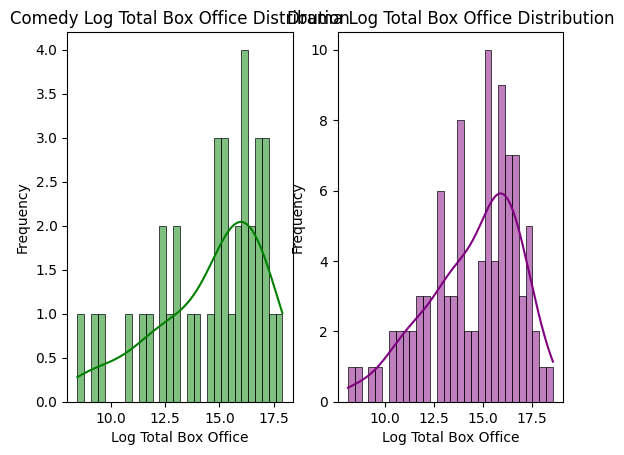

In [95]:
# 先把資料分成budget_low跟budget_high
# 這兩筆資料分別用 genre 分類(Romantic Comedy ; Thriller/Suspense ; Comedy ; Drama)

budget_low_df = filtered_df[filtered_df['budget_category'] == 'Low']
budget_high_df = filtered_df[filtered_df['budget_category'] == 'High']

low_romantic_comedy_df = budget_low_df[budget_low_df['genre'] == 'Romantic Comedy']['log_total_box_office']
low_thriller_suspense_df = budget_low_df[budget_low_df['genre'] == 'Thriller/Suspense']['log_total_box_office']
low_comedy_df = budget_low_df[budget_low_df['genre'] == 'Comedy']['log_total_box_office']
low_drama_df = budget_low_df[budget_low_df['genre'] == 'Drama']['log_total_box_office']

high_romantic_comedy_df = budget_high_df[budget_high_df['genre'] == 'Romantic Comedy']['log_total_box_office']
high_thriller_suspense_df = budget_high_df[budget_high_df['genre'] == 'Thriller/Suspense']['log_total_box_office']
high_comedy_df = budget_high_df[budget_high_df['genre'] == 'Comedy']['log_total_box_office']
high_drama_df = budget_high_df[budget_high_df['genre'] == 'Drama']['log_total_box_office']

print("budget_low_df的資料筆數：", len(budget_low_df))

print("Romantic Comedy 資料筆數：", len(low_romantic_comedy_df))
print("Thriller/Suspense 資料筆數：", len(low_thriller_suspense_df))
print("Comedy 資料筆數：", len(low_comedy_df))
print("Drama 資料筆數：", len(low_drama_df))
print("\n")

print("budget_high_df的資料筆數：", len(budget_high_df))

print("Romantic Comedy 資料筆數：", len(high_romantic_comedy_df))
print("Thriller/Suspense 資料筆數：", len(high_thriller_suspense_df))
print("Comedy 資料筆數：", len(high_comedy_df))
print("Drama 資料筆數：", len(high_drama_df))

# 畫圖，用subplot把圖畫一起
# low的圖
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(low_romantic_comedy_df, bins=30, kde=True, color='blue')
plt.title('Romantic Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(low_thriller_suspense_df, bins=30, kde=True, color='red')
plt.title('Thriller/Suspense Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

plt.subplot(1, 2, 1)
sns.histplot(low_comedy_df, bins=30, kde=True, color='green')
plt.title('Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(low_drama_df, bins=30, kde=True, color='purple')
plt.title('Drama Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

# high的圖
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(high_romantic_comedy_df, bins=30, kde=True, color='blue')
plt.title('Romantic Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(high_thriller_suspense_df, bins=30, kde=True, color='red')
plt.title('Thriller/Suspense Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

plt.subplot(1, 2, 1)
sns.histplot(high_comedy_df, bins=30, kde=True, color='green')
plt.title('Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(high_drama_df, bins=30, kde=True, color='purple')
plt.title('Drama Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()



常態性檢定 (Shapiro-Wilk test)  
只有 Romantic Comedy 的資料筆數 < 30   
其他 Genre 畫 QQ plot  

這還沒有分budget，但應該接續任務一，分成low跟high(就跟上面一樣有先分budget再分genre
)

In [96]:
# Clean genres (keep only 4 categories of interest)
target_genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']
filtered_df = filtered_df[filtered_df['genre'].isin(target_genres)]

# Fit model
model = ols('log_total_box_office ~ C(budget_category) * C(genre)', data=filtered_df).fit()

# Shapiro-Wilk test for normality of residuals
shapiro_test = shapiro(model.resid)
print("Shapiro-Wilk Test:")
print(f"Statistic = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")

# Create group combinations
groups = []
for budget in ['Low', 'High']:
    for g in target_genres:
        group = filtered_df[(filtered_df['budget_category'] == budget) & (filtered_df['genre'] == g)]
        groups.append(group['log_total_box_office'])

# Bartlett test
stat, p = bartlett(*groups)
print("\nBartlett’s Test:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")


Shapiro-Wilk Test:
Statistic = 0.9679, p-value = 0.0000

Bartlett’s Test:
Statistic = 9.2702, p-value = 0.2338


In [97]:
from scipy.stats import rankdata

# Rank transform the dependent variable
filtered_df['ranked_box_office'] = rankdata(filtered_df['log_total_box_office'])

# Two-way ANOVA on ranks
model = ols('ranked_box_office ~ C(budget_category) + C(genre) + C(budget_category):C(genre)', data=filtered_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                   sum_sq     df          F        PR(>F)
C(budget_category)           6.044771e+05    1.0  38.318185  1.371044e-09
C(genre)                     1.143355e+05    3.0   2.415932  6.586976e-02
C(budget_category):C(genre)  1.133739e+05    3.0   2.395614  6.765102e-02
Residual                     6.988414e+06  443.0        NaN           NaN


C:\Users\User\AppData\Local\Temp\ipykernel_179440\3703126560.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


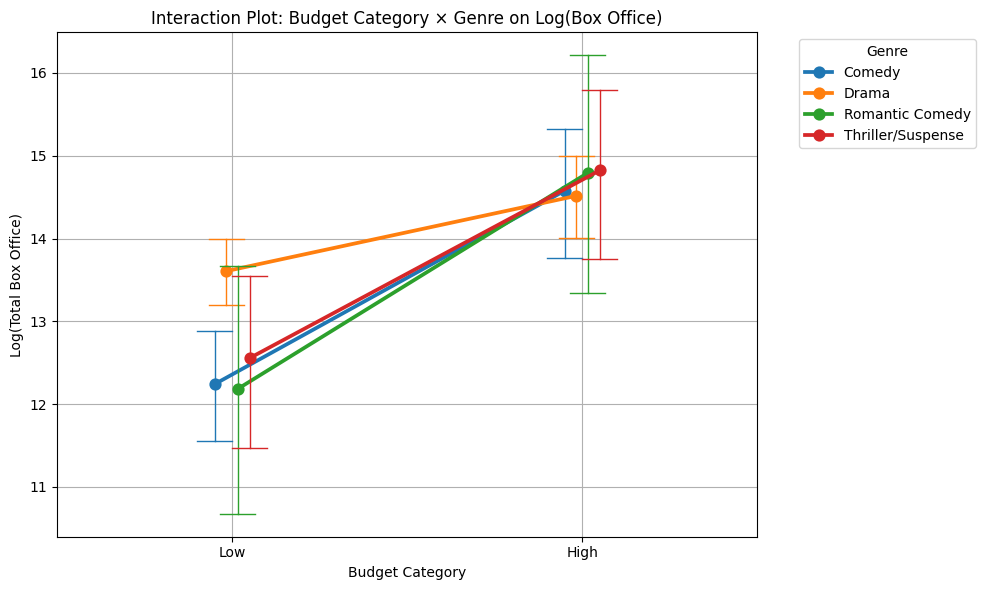

In [98]:
# Ensure budget_category and genre are categorical with proper order
filtered_df['budget_category'] = filtered_df['budget_category'].astype('category')
filtered_df['genre'] = filtered_df['genre'].astype('category')

# Interaction plot using seaborn lineplot (grouped by genre)
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=filtered_df,
    x='budget_category',
    y='log_total_box_office',
    hue='genre',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='tab10'
)

plt.title('Interaction Plot: Budget Category × Genre on Log(Box Office)')
plt.ylabel('Log(Total Box Office)')
plt.xlabel('Budget Category')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


Task 3

In [99]:
# Define the filtered source and genre categories
selected_sources = ["Original Screenplay", "Based on Fiction Book/Short Story", "Based on Play"]
selected_genres = ["Thriller/Suspense", "Comedy", "Drama"]

# Filter the DataFrame
subset_df = filtered_df[
    filtered_df['source'].isin(selected_sources) &
    filtered_df['genre'].isin(selected_genres)
].copy()

# Drop NA if necessary
subset_df = subset_df.dropna(subset=['log_total_box_office'])

In [100]:
# Convert to string before concatenation
subset_df['group'] = subset_df['source'].astype(str) + " | " + subset_df['genre'].astype(str)

# Shapiro-Wilk test
for g in subset_df['group'].unique():
    data = subset_df[subset_df['group'] == g]['log_total_box_office']
    stat, p = stats.shapiro(data)
    print(f"{g} → Shapiro W={stat:.4f}, p={p:.4f} → {'Normal' if p > 0.05 else 'Not Normal'}")

Original Screenplay | Drama → Shapiro W=0.9572, p=0.0000 → Not Normal
Based on Fiction Book/Short Story | Drama → Shapiro W=0.9073, p=0.0127 → Not Normal
Original Screenplay | Thriller/Suspense → Shapiro W=0.9237, p=0.0012 → Not Normal
Original Screenplay | Comedy → Shapiro W=0.9533, p=0.0043 → Not Normal
Based on Fiction Book/Short Story | Thriller/Suspense → Shapiro W=0.9496, p=0.7134 → Normal
Based on Play | Drama → Shapiro W=1.0000, p=0.9995 → Normal
Based on Play | Comedy → Shapiro W=0.8072, p=0.0926 → Normal
Based on Fiction Book/Short Story | Comedy → Shapiro W=0.9097, p=0.2788 → Normal


In [101]:
# Create list of arrays per group
group_data = [
    subset_df[subset_df['group'] == g]['log_total_box_office'].values
    for g in subset_df['group'].unique()
]

# Bartlett’s test
stat, p = stats.bartlett(*group_data)
print(f"Bartlett’s test: Stat = {stat:.4f}, p = {p:.4f} → {'Equal Variances' if p > 0.05 else 'Unequal Variances'}")

Bartlett’s test: Stat = 9.9882, p = 0.1892 → Equal Variances


In [102]:
# Rank transform the dependent variable
subset_df['ranked_box_office'] = rankdata(subset_df['log_total_box_office'])

# Two-way ANOVA on ranks
model = ols('ranked_box_office ~ C(source) + C(genre) + C(source):C(genre)', data=filtered_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                          sum_sq     df             F        PR(>F)
C(source)           2.084774e+06    8.0  1.512678e+01  2.300509e-09
C(genre)            9.072884e-08    3.0  1.755502e-12  9.999989e-01
C(source):C(genre)  3.556452e+05   24.0  8.601675e-01  5.957681e-01
Residual            7.218330e+06  419.0           NaN           NaN


c:\Users\User\Desktop\114Spring-Statistics(I)(2)\Statistics_Final_Project\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\User\Desktop\114Spring-Statistics(I)(2)\Statistics_Final_Project\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\User\Desktop\114Spring-Statistics(I)(2)\Statistics_Final_Project\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 13
  warnings.warn('covariance of constraints does not have full '


C:\Users\User\AppData\Local\Temp\ipykernel_179440\2538079644.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


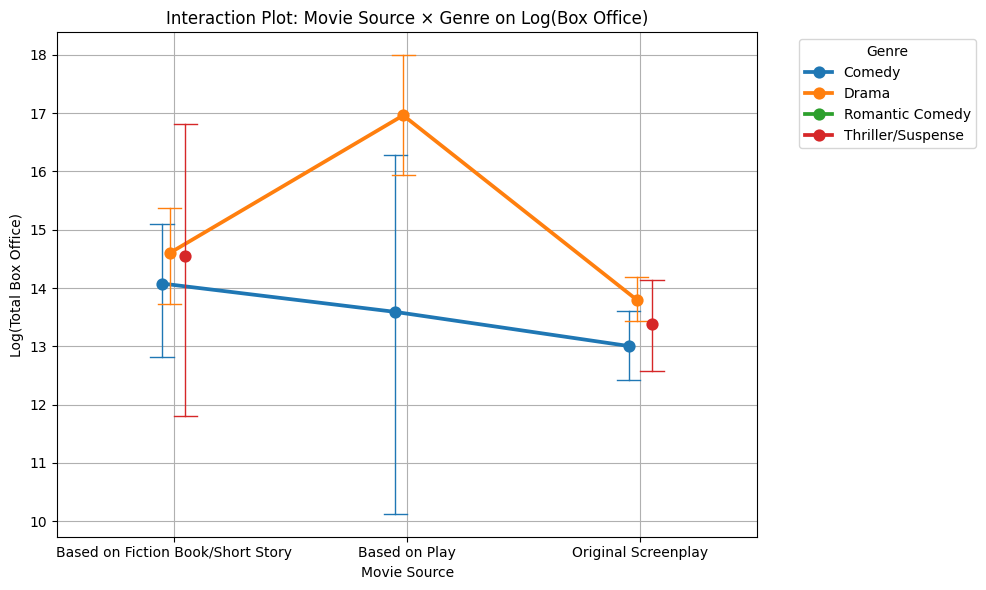

In [104]:
# Ensure budget_category and genre are categorical with proper order
subset_df['source'] = subset_df['source'].astype('category')
subset_df['genre'] = subset_df['genre'].astype('category')

# Interaction plot using seaborn lineplot (grouped by genre)
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=subset_df,
    x='source',
    y='log_total_box_office',
    hue='genre',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='tab10'
)

plt.title('Interaction Plot: Movie Source × Genre on Log(Box Office)')
plt.ylabel('Log(Total Box Office)')
plt.xlabel('Movie Source')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()
